In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import sys

import itertools

import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
import metpy.calc as mpcalc
from metpy.units import units
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy
from metpy import constants

from skimage.measure import label, regionprops

phys_table = [1,2,7,8,13,14, 3,4,9,10,15,16, 5,6,11,12,17,18]

#                 YSU       |      MYJ      |       MYNN

phys_table = [x-1 for x in phys_table]

print(phys_table)

storm_size = [10, 120]

lats = [35.294243, 43.726334]
lons = [-92.01535, -80.48016]

from operator import itemgetter


[0, 1, 6, 7, 12, 13, 2, 3, 8, 9, 14, 15, 4, 5, 10, 11, 16, 17]


In [2]:
import datetime
#--------------------------------------------------------------------------------------------------
# my datetime stuff
def my_datetime(input: list, time_delta=None, format=None, summary_file=False):

    """
        Inputs: input (list) list of [YY, MM, DD, HH, MM, SS]

                time_delta: (list)  -> [hours, minutes, seconds]
                                
                                or
                                    ->  [Days, hours, minutes, seconds]
                                    
                format:  (string)   ->  '%Y-%m-%d::%H-%M'
                
                                or
                                    ->  '%Y%d_%H%M'  (usefull for WoFS files)

        returns:  Datetime object or string if format is supplied.
        
    """
    try:
        hhmm = datetime.datetime(*input)
    except ValueError:
        print(f"Input is invalid, need YYMMDDHHMM {input}")
        return None
        
    if time_delta == None:
        
        if format == None:
            return hhmm
        else:
            return hhmm.strftime(format)
    
    else:
        
        if len(time_delta) == 3:
            timeD = datetime.timedelta(days=time_delta[0], hours=time_delta[1], minutes=time_delta[2])
        else:
            timeD = datetime.timedelta(days=time_delta[0], hours=time_delta[1], minutes=time_delta[2], seconds=time_delta[3])
            
        if format == None and summary_file == False:
            
            return hhmm + timeD
            
        else:
            
            if summary_file:

                return f"{hhmm.strftime('%Y%m%d_%H%M')}_{(hhmm+timeD).strftime('%H%M')}"

            else:  
                return (hhmm+timeD).strftime(format)

print( my_datetime([2024,5,7,19], time_delta=[0,0,65]) )
print( my_datetime([2024,5,7,19], time_delta=[0,0,65], summary_file=True ))

2024-05-07 20:05:00
20240507_1900_2005


In [5]:
# New section to "count" storms

def get_counts(ds, ens, cref_thresh=45., storm_size=storm_size, field_name='comp_dz'):

    if ens == 1:

        regions = []

        mask_cref = np.where(ds[field_name] >= cref_thresh, True, False)

        f_mask = mask_cref.astype(np.int8)

        mpas_label_array, counts = label(f_mask, connectivity=2, return_num = True)
        
        # Calculate region properties
        
        for l, props in enumerate(regionprops(mpas_label_array)):
                regions.append(props.area)

        return counts, regions
    else:
            
        counts = np.zeros( (ens,), dtype='int')
        
        mask_cref = np.where(ds[field_name] > cref_thresh, True, False)

        f_mask = mask_cref.astype(np.int8)

        area   = []

        for n in np.arange(ens):

            mpas_label_array, counts[n] = label(f_mask[phys_table[n]], connectivity=2, return_num = True)

            # Calculate region properties

            number_of_areas = len(regionprops(mpas_label_array))
        
            for l, props in enumerate(regionprops(mpas_label_array)):
                area.append(props.area)

        return counts, area


In [6]:
def plot_counts(runs, dt_string, title, ens=18, nstep=25, skip=0, plot_mrms=None):
                
    fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(10,5))

    counts  = np.zeros((len(runs), ens, nstep), dtype='int')
    regions = {}
    areas   = {}

    time = 5*np.arange(nstep)

    for r, run in enumerate(runs):
    
        print(f"Now computing stats for {run[0]} CREF_THRES = {run[3]}\n")

        area = []
        prop = []

        for n in np.arange(nstep):
    
            min = int(n*5)
        
            file_string = my_datetime(dt_string, time_delta=[0,0,min], summary_file=True)
        
        # MPAS
            
            ds = xr.open_dataset(os.path.join(run[0], f"wofs_ALL_{n:02}_{file_string}.nc"))

            # if n == 0:
            #     print(ds.xlat.max())
            #     print(ds.xlat.min())
            #     print(ds.xlon.max())
            #     print(ds.xlon.min())
        
            the_count, the_area = get_counts(ds, ens, cref_thresh = run[3])

            counts[r,:,n] = the_count
                      
            area.append(the_area)
                
            ds.close()

        # for m in np.arange(ens):
        #     rrr = area[0:25][m][0:-1]
        #     area2[m] = list(itertools.chain(*rrr))
        #     print(m,len(area2[m]))

        regions[r] = list(itertools.chain(*area))
        
        # axs[2].plot(time[skip:], counts[r,:,skip:].sum(axis=(0)), color=run[2], label=run[1])

        axs[0].plot(time[skip:], counts[r,:,skip:].mean(axis=(0)), color=run[2], label=run[1])
        
        # reorder the array to isolate PBL

        axs[1].plot(np.arange(ens), counts[r,:,skip:].mean(axis=1), color=run[2], label=run[1])

    if plot_mrms:

        with open(plot_mrms, 'rb') as file:
            data = pickle.load(file)
            
        axs[0].plot(data['time'], data['pixels'], linestyle='--', color='k', label='MRMS')
        # axs[1].hlines(xmin=0, xmax=17, y=data['objects'].mean(), linestyle='--', color='k', label='MRMS')

    # axs[2].set_title(title, fontsize=10)
    # axs[2].set_xlabel('Forecast time in minutes')
    # axs[2].set_ylabel('Pixel Count')
    # axs[2].set_ylim(1000,3000)
    # axs[2].legend();

    axs[0].set_title(title, fontsize=10)
    axs[0].set_xlabel('Forecast time in minutes')
    axs[0].set_ylabel(f'PIXELS COUNT')
    axs[0].set_ylim(0,200)
    axs[0].legend();

    axs[1].set_title(title, fontsize=10)
    axs[1].set_xlim(0,17)
    axs[1].set_ylim(0000,200)
    yrange = axs[1].get_ylim()
    axs[1].vlines(x=5,  ymin=yrange[0], ymax=yrange[1], colors='k', alpha = 0.25)
    axs[1].vlines(x=11, ymin=yrange[0], ymax=yrange[1], colors='k', alpha = 0.25)
    new_ticks  = [3, 8, 13]
    new_labels = ['YSU', 'MYJ', 'MYNN']
    axs[1].set_xticks(new_ticks)
    axs[1].set_xticklabels(new_labels)
    axs[1].set_xlabel('ENS MEMBERS')
    axs[1].set_ylabel(f'PIXELS COUNT')
    axs[1].legend()

    # fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(15,5))

    # bins = [10,25,50,100,125,150,200,300,400,500,750]
    # # bins = [10,25,50,100,125,150,200,300,400]

    # for r, run in enumerate(runs):

    #     axs[r].hist(regions[r], bins=bins, edgecolor='k', label=run[1])
    #     axs[r].set_ylim(1,13000)
    #     axs[r].set_xlim(0,bins[-1])
    #     axs[r].hist(data['area'],bins=bins, edgecolor='k', label='MRMS')
    #     axs[r].legend()
    #     axs[r].set_yscale('log', nonpositive='clip')
    #     axs[r].set_xlabel('AREA in 3KM Pixels')
    #     axs[r].set_ylabel(f'LOG of FREQUENCY')
    #     axs[r].set_title(title[-14:], fontsize=10)

    return counts, regions

Now computing stats for /work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/1900 CREF_THRES = 44.234375

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_gsl2/1900 CREF_THRES = 40.28125

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_snglMYNN/1900 CREF_THRES = 38.875

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_V822Reduced/1900 CREF_THRES = 38.81

Now computing stats for /work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/1900 CREF_THRES = 34.8125

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_gsl2/1900 CREF_THRES = 28.578125

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_snglMYNN/1900 CREF_THRES = 26.109375

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_V822Reduced/1900 CREF_THRES = 25.9



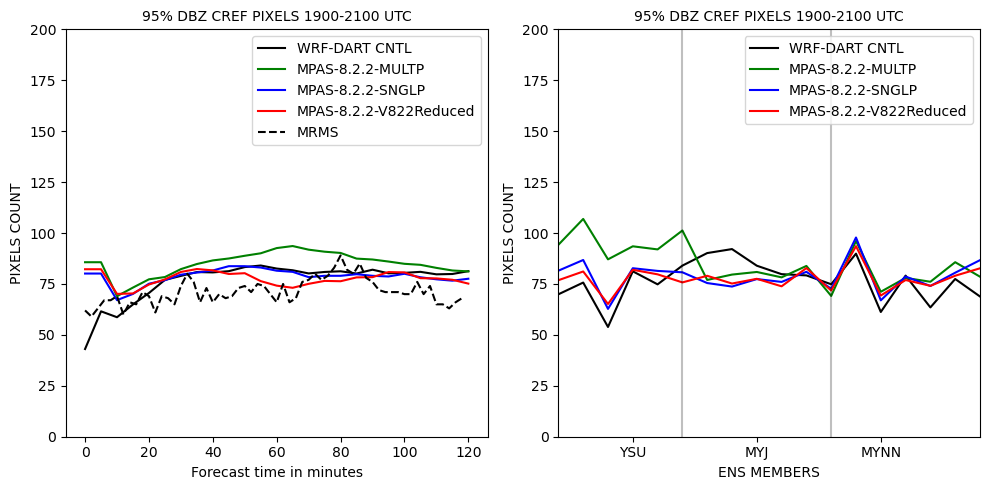

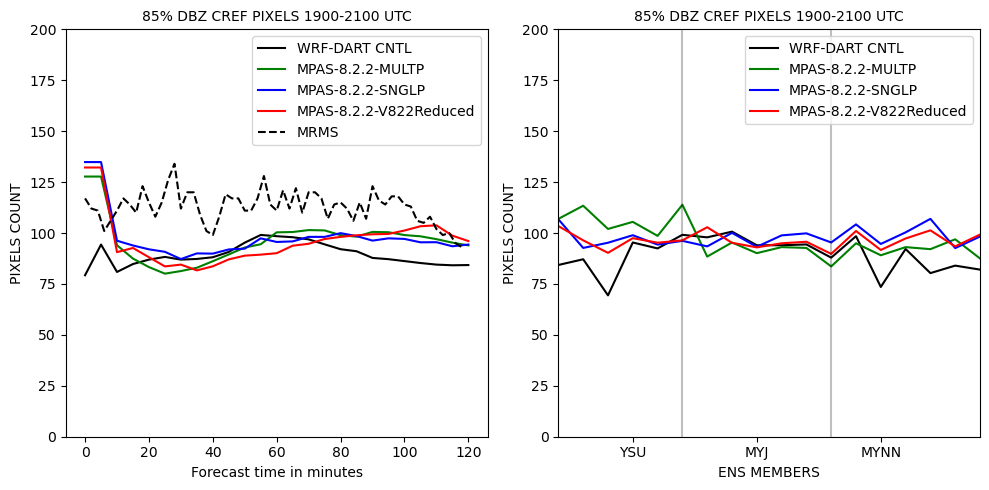

In [9]:
nstep = 25
ens   = 18
cref_thresh = [25,]
percent = [95, 85]

dt_string = [2024,5,7,19]

#  95 %
runs  = [
# ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/1900','MPAS KM2', 'r', 41.515625],
# ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmncar/1900','MPAS NCAR', 'r', 41.64],

['/work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/1900', 'WRF-DART CNTL', 'k', 44.234375],
['/scratch/wofs_mpas/run_dirs/summary_files/20240507_gsl2/1900', 'MPAS-8.2.2-MULTP', 'g', 40.28125],
['/scratch/wofs_mpas/run_dirs/summary_files/20240507_snglMYNN/1900','MPAS-8.2.2-SNGLP', 'b', 38.875 ],
['/scratch/wofs_mpas/run_dirs/summary_files/20240507_V822Reduced/1900','MPAS-8.2.2-V822Reduced', 'r',38.81],
        ]

title = f"{percent[0]}% DBZ CREF PIXELS 1900-2100 UTC"

counts1 = plot_counts(runs, dt_string, title, ens=18, nstep = 25, plot_mrms='./mrms1900_95.pickle')


# 85 --> 30 dbz
runs  = [
         ['/work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/1900', 'WRF-DART CNTL', 'k', 34.8125],
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_gsl2/1900', 'MPAS-8.2.2-MULTP', 'g', 28.578125],
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_snglMYNN/1900','MPAS-8.2.2-SNGLP', 'b', 26.109375],
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_V822Reduced/1900','MPAS-8.2.2-V822Reduced', 'r',25.9],
        ]

title = f"{percent[1]}% DBZ CREF PIXELS 1900-2100 UTC"

counts1 = plot_counts(runs, dt_string, title, ens=18, nstep = 25, plot_mrms='./mrms1900_85.pickle')


Now computing stats for /work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2000 CREF_THRES = 45.6875

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_gsl2/2000 CREF_THRES = 41.515625

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_snglMYNN/2000 CREF_THRES = 40.46875

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_V822Reduced/2000 CREF_THRES = 41.72

Now computing stats for /work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2000 CREF_THRES = 35.625

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_gsl2/2000 CREF_THRES = 31.0625

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_snglMYNN/2000 CREF_THRES = 30.390625

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_V822Reduced/2000 CREF_THRES = 29.39



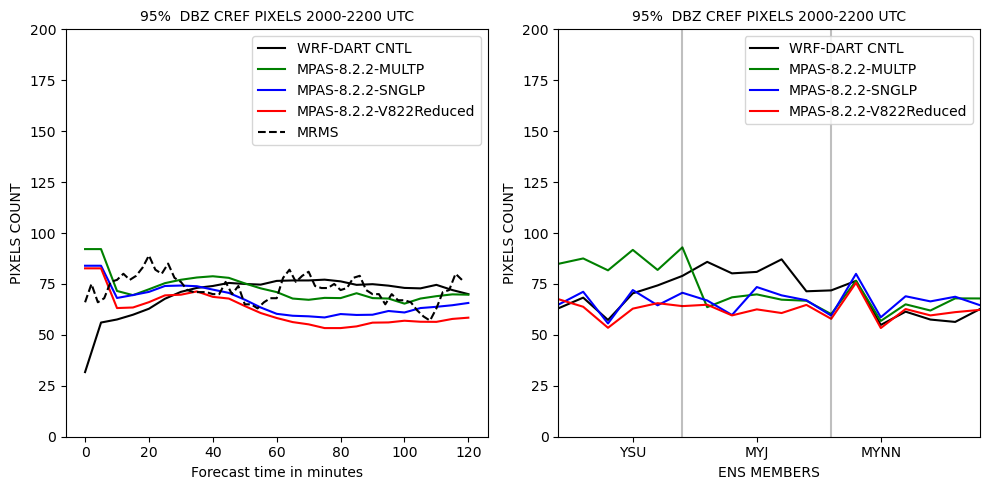

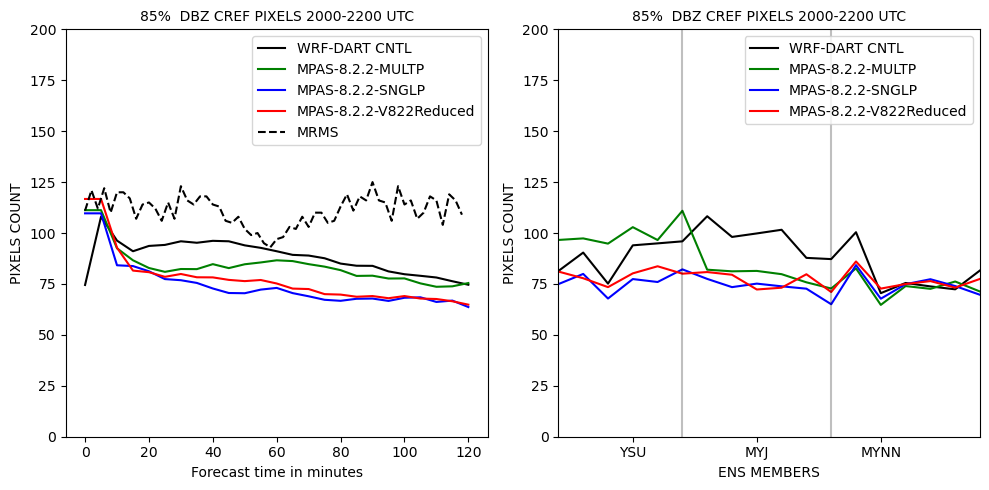

In [10]:
#------------------------------------------------------------------------------------
nstep = 25
ens   = 18

dt_string = [2024,5,7,20]

runs  = [
         # ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmncar/2000','MPAS NCAR', 'r', 42.45],
         # ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_V822YSU/2000','GSL-YSU', 'c', 41.76],
         ['/work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2000', 'WRF-DART CNTL', 'k',45.6875],
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_gsl2/2000', 'MPAS-8.2.2-MULTP', 'g', 41.515625],   
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_snglMYNN/2000','MPAS-8.2.2-SNGLP', 'b', 40.46875 ],
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_V822Reduced/2000','MPAS-8.2.2-V822Reduced', 'r',41.72],

        ]


title = f"{percent[0]}%  DBZ CREF PIXELS 2000-2200 UTC"
counts2 = plot_counts(runs, dt_string, title, ens=18, nstep = 25, plot_mrms='./mrms2000_95.pickle')

runs  = [
         ['/work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2000', 'WRF-DART CNTL', 'k',35.625],
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_gsl2/2000', 'MPAS-8.2.2-MULTP', 'g', 31.0625],   
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_snglMYNN/2000','MPAS-8.2.2-SNGLP', 'b', 30.390625 ],
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_V822Reduced/2000','MPAS-8.2.2-V822Reduced', 'r',29.39],

        ]


title = f"{percent[1]}%  DBZ CREF PIXELS 2000-2200 UTC"
counts2 = plot_counts(runs, dt_string, title, ens=18, nstep = 25, plot_mrms='./mrms2000_85.pickle')

Now computing stats for /work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2100 CREF_THRES = 46.609375

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_gsl2/2100 CREF_THRES = 43.609375

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_snglMYNN/2100 CREF_THRES = 44.078125

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_snglNOZeros/2100 CREF_THRES = 41.45

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_gsl2/2100 CREF_THRES = 31.0625

Now computing stats for /work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2100 CREF_THRES = 35.625

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_snglMYNN/2100 CREF_THRES = 30.390625

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_snglNOZeros/2100 CREF_THRES = 31.0



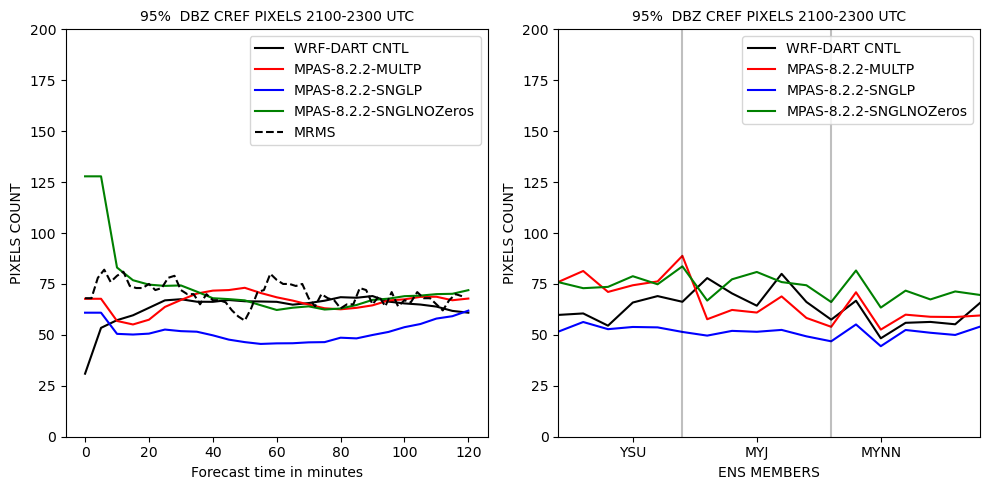

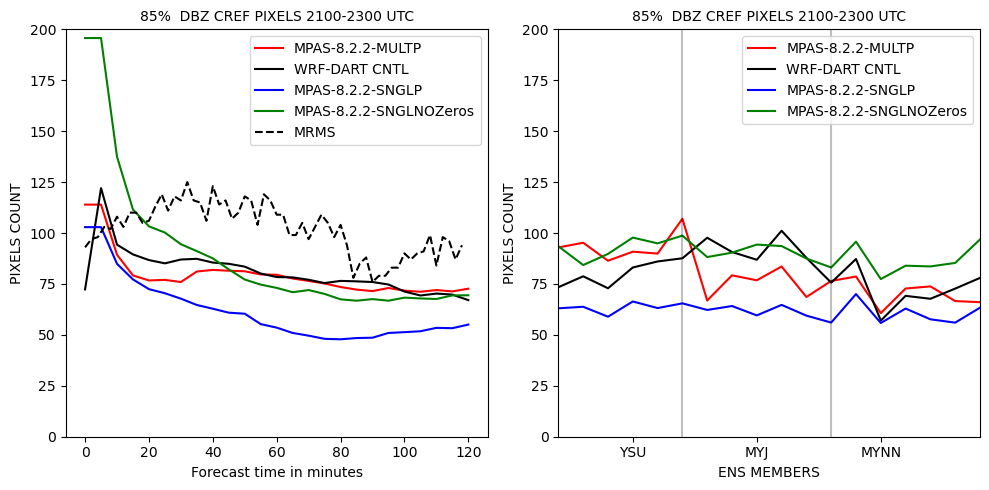

In [33]:
#------------------------------------------------------------------------------------
nstep = 25
ens   = 18

dt_string = [2024,5,7,21]

runs  = [
    #  ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmncar/2100','MPAS NCAR', 'r', 44.07],
    # ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_V822YSU/2100','GSL-YSU', 'c', 43.64],
['/work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2100', 'WRF-DART CNTL', 'k', 46.609375],
['/scratch/wofs_mpas/run_dirs/summary_files/20240507_gsl2/2100', 'MPAS-8.2.2-MULTP', 'r', 43.609375],
['/scratch/wofs_mpas/run_dirs/summary_files/20240507_snglMYNN/2100','MPAS-8.2.2-SNGLP', 'b', 44.078125],
    ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_snglNOZeros/2100','MPAS-8.2.2-SNGLNOZeros', 'g',41.45],
        ]
title = f"{percent[0]}%  DBZ CREF PIXELS 2100-2300 UTC"
counts3 = plot_counts(runs, dt_string, title, ens=18, nstep = 25, plot_mrms='./mrms2100_95.pickle')

runs  = [
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_gsl2/2100', 'MPAS-8.2.2-MULTP', 'r', 31.0625],
         ['/work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2100', 'WRF-DART CNTL', 'k', 35.625],
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_snglMYNN/2100','MPAS-8.2.2-SNGLP', 'b', 30.390625 ],
        ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_snglNOZeros/2100','MPAS-8.2.2-SNGLNOZeros', 'g',31.0],
        ]
title = f"{percent[1]}%  DBZ CREF PIXELS 2100-2300 UTC"
counts3 = plot_counts(runs, dt_string, title, ens=18, nstep = 25, plot_mrms='./mrms2100_85.pickle')

In [12]:
def get_sorted_files(directory, pattern):
  """
  Gets a list of files in a directory matching a wildcard pattern, 
  sorts them alphabetically, and returns the sorted list.

  Args:
    directory: The path to the directory to search.
    pattern: The wildcard pattern to match (e.g., "*.txt", "image*").

  Returns:
    A list of sorted file names that match the pattern, or an empty list if 
    no files match or the directory doesn't exist.
  """
  try:
    file_paths = glob.glob(os.path.join(directory, pattern))
    sorted_files = sorted(file_paths)
    return sorted_files
  except FileNotFoundError:
    return []




In [13]:
# MRMS

directory = "/work/wicker/MPAS_WRF_W/MRMS_20240508/1900/"
pattern    = "*.grib2"

files = get_sorted_files(directory, pattern)

nstep = len(files)
dt    = 120 / nstep

time = dt*np.arange(nstep)

mrms_counts  = np.zeros((nstep,), dtype='int')
area = []

for n, file in enumerate(files):

    if (n % 10 ) == 0:
        print(f"Now computing stats for {file}\n")
            
    ds = xr.open_dataset(file, engine='cfgrib')

    cropped_ds = ds.sel(latitude=slice(lats[1],lats[0]), longitude=slice(lons[0]+360,lons[1]+360))

    cropped_ds2 = cropped_ds.coarsen(latitude=3,boundary='trim').mean().coarsen(longitude=3,boundary='trim').median()
    
    the_count, the_region = get_counts(cropped_ds2, 1, storm_size=None, field_name = 'unknown', cref_thresh = 39.03)

    mrms_counts[n] = the_count
    area.append(the_region)
        
    ds.close()

mrms_regions = list(itertools.chain(*area))

print("finished..")

Now computing stats for /work/wicker/MPAS_WRF_W/MRMS_20240508/1900/MRMS_MergedReflectivityComposite_00.50_20240508-190043.grib2

Now computing stats for /work/wicker/MPAS_WRF_W/MRMS_20240508/1900/MRMS_MergedReflectivityComposite_00.50_20240508-192242.grib2

Now computing stats for /work/wicker/MPAS_WRF_W/MRMS_20240508/1900/MRMS_MergedReflectivityComposite_00.50_20240508-194241.grib2

finished..


In [14]:
mrms_data = {'time': time, 'pixels': mrms_counts, 'area': mrms_regions}

# Pickling (serialization)
with open('20240508_mrms1900_95.pickle', 'wb') as file:
    pickle.dump(mrms_data, file)
